<a href="https://colab.research.google.com/github/chefdarek/DS-Unit-2-Classification-1/blob/master/DS_Sprint_Challenge_7_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
!pip install category_encoders
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline

In [0]:
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [3]:
df.dtypes

game_id                      int64
game_event_id                int64
player_name                 object
period                       int64
minutes_remaining            int64
seconds_remaining            int64
action_type                 object
shot_type                   object
shot_zone_basic             object
shot_zone_area              object
shot_zone_range             object
shot_distance                int64
loc_x                        int64
loc_y                        int64
shot_made_flag               int64
htm                         object
vtm                         object
season_type                 object
scoremargin_before_shot    float64
dtype: object

In [4]:
df.index


DatetimeIndex(['2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28', '2009-10-28',
               ...
               '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05', '2019-06-05'], dtype='datetime64[ns]', name='game_date', length=13958, freq=None)

In [5]:
df.tail()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2019-06-05,41800403,570,Stephen Curry,4,8,1,Pullup Jump shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,12,3,120,1,GSW,TOR,Playoffs,-13.0
2019-06-05,41800403,573,Stephen Curry,4,7,16,Floating Jump shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,11,114,-5,0,GSW,TOR,Playoffs,-14.0
2019-06-05,41800403,602,Stephen Curry,4,5,27,Step Back Jump shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-217,149,0,GSW,TOR,Playoffs,-17.0
2019-06-05,41800403,608,Stephen Curry,4,4,50,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,59,49,0,GSW,TOR,Playoffs,-16.0
2019-06-05,41800403,658,Stephen Curry,4,2,47,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24,-226,104,0,GSW,TOR,Playoffs,-12.0


In [6]:
df.isna().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [7]:
conts = df.select_dtypes('number')
conts.describe()

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,shot_distance,loc_x,loc_y,shot_made_flag,scoremargin_before_shot
count,1.395800e+04,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000
mean,2.442837e+07,270.438458,2.412380,4.727540,28.506376,17.600373,-0.554162,131.257988,0.472919,1.615561
std,7.226620e+06,169.927170,1.125828,3.331646,17.597701,10.295807,124.721869,102.666562,0.499284,10.127139
min,2.090002e+07,2.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,0.000000,-39.000000
25%,2.120091e+07,109.000000,1.000000,2.000000,13.000000,8.000000,-96.000000,23.000000,0.000000,-4.000000
50%,2.150026e+07,275.500000,2.000000,4.000000,29.000000,22.000000,1.000000,141.000000,0.000000,1.000000
75%,2.170096e+07,398.000000,3.000000,7.000000,44.000000,25.000000,95.000000,219.000000,1.000000,8.000000
max,4.180040e+07,752.000000,6.000000,11.000000,59.000000,83.000000,247.000000,811.000000,1.000000,43.000000


/usr/local/lib/python3.6/dist-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


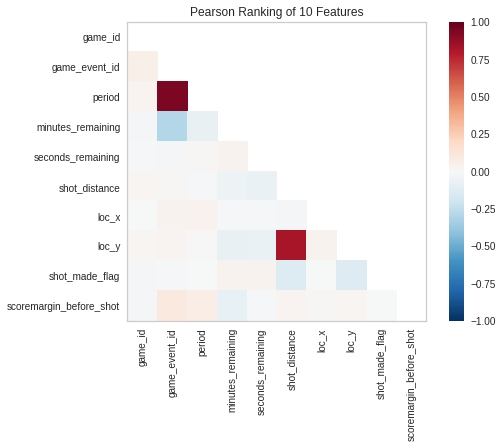

In [8]:
from yellowbrick.features import Rank2D
X = conts
y = df.shot_made_flag
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X,y)
visualizer.poof()

In [9]:
cats = df.select_dtypes('object')
cats.describe()

,player_name,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,htm,vtm,season_type
count,13958,13958,13958,13958,13958,13958,13958,13958,13958
unique,1,53,2,7,6,5,32,32,2
top,Stephen Curry,Jump Shot,2PT Field Goal,Above the Break 3,Center(C),24+ ft.,GSW,GSW,Regular Season
freq,13958,6657,7135,5695,5987,6721,6871,7087,11846


In [10]:
df.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
player_name,13958,1,Stephen Curry,13958
shot_type,13958,2,2PT Field Goal,7135
season_type,13958,2,Regular Season,11846
shot_zone_range,13958,5,24+ ft.,6721
shot_zone_area,13958,6,Center(C),5987
shot_zone_basic,13958,7,Above the Break 3,5695
htm,13958,32,GSW,6871
vtm,13958,32,GSW,7087
action_type,13958,53,Jump Shot,6657


In [0]:
df = df.drop(['game_id', 'game_event_id','player_name',], axis=1)

Baseline Predictions

In [12]:
y_train = df['shot_made_flag']
y_train.value_counts(normalize=True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [14]:
#autopredict on AS
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5270812437311936

In [15]:
#predicting 47% 
df.shot_made_flag.mean()

0.4729187562688064

Test Train Validate Split


In [16]:
df_train = df['2009-10-28':'2017-9-28']
y_train = df_train['shot_made_flag']
df_train = df_train.drop('shot_made_flag', axis=1).copy()

print(df_train.shape)
df_train.head()

(11081, 15)


,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,
2009-10-28,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,GSW,HOU,Regular Season,2.0
2009-10-28,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,GSW,HOU,Regular Season,0.0
2009-10-28,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,GSW,HOU,Regular Season,-4.0
2009-10-28,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,GSW,HOU,Regular Season,-4.0
2009-10-28,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,GSW,HOU,Regular Season,0.0


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11081 entries, 2009-10-28 to 2017-06-12
Data columns (total 15 columns):
period                     11081 non-null int64
minutes_remaining          11081 non-null int64
seconds_remaining          11081 non-null int64
action_type                11081 non-null object
shot_type                  11081 non-null object
shot_zone_basic            11081 non-null object
shot_zone_area             11081 non-null object
shot_zone_range            11081 non-null object
shot_distance              11081 non-null int64
loc_x                      11081 non-null int64
loc_y                      11081 non-null int64
htm                        11081 non-null object
vtm                        11081 non-null object
season_type                11081 non-null object
scoremargin_before_shot    11081 non-null float64
dtypes: float64(1), int64(6), object(8)
memory usage: 1.4+ MB


In [18]:
df_val = df['2017-9-29':'2018-9-28'].copy()
y_val = df_val['shot_made_flag']
df_val = df_val.drop('shot_made_flag', axis=1)
print(df_val.shape)
df_val.info()

(1168, 15)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1168 entries, 2017-10-17 to 2018-06-08
Data columns (total 15 columns):
period                     1168 non-null int64
minutes_remaining          1168 non-null int64
seconds_remaining          1168 non-null int64
action_type                1168 non-null object
shot_type                  1168 non-null object
shot_zone_basic            1168 non-null object
shot_zone_area             1168 non-null object
shot_zone_range            1168 non-null object
shot_distance              1168 non-null int64
loc_x                      1168 non-null int64
loc_y                      1168 non-null int64
htm                        1168 non-null object
vtm                        1168 non-null object
season_type                1168 non-null object
scoremargin_before_shot    1168 non-null float64
dtypes: float64(1), int64(6), object(8)
memory usage: 146.0+ KB


In [19]:
df_test = df['2018-9-1':]
y_test = df_test['shot_made_flag']
df_test = df_test.drop('shot_made_flag', axis=1).copy()

print(df_test.shape)
df_test.info()


(1709, 15)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1709 entries, 2018-10-16 to 2019-06-05
Data columns (total 15 columns):
period                     1709 non-null int64
minutes_remaining          1709 non-null int64
seconds_remaining          1709 non-null int64
action_type                1709 non-null object
shot_type                  1709 non-null object
shot_zone_basic            1709 non-null object
shot_zone_area             1709 non-null object
shot_zone_range            1709 non-null object
shot_distance              1709 non-null int64
loc_x                      1709 non-null int64
loc_y                      1709 non-null int64
htm                        1709 non-null object
vtm                        1709 non-null object
season_type                1709 non-null object
scoremargin_before_shot    1709 non-null float64
dtypes: float64(1), int64(6), object(8)
memory usage: 213.6+ KB


In [0]:
catcode = [
    'action_type','shot_zone_basic',
    'shot_zone_area','shot_zone_range',
    'htm','vtm',
]


In [0]:
numeric_features = df_train.select_dtypes('number').columns.tolist()
features = catcode + numeric_features

X_train_subset = df_train[features]
X_val_subset = df_val[features]
X_test = df_test[features]

Random Forest 

In [0]:
 Rf = RandomForestClassifier(n_estimators=800, n_jobs=-1)

In [23]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    QuantileTransformer(),
    IterativeImputer(), 
    Rf
                                                                           
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train_subset, y_train)
print('Train Accuracy', pipeline.score(X_train_subset, y_train))
print('Validation Accuracy', pipeline.score(X_val_subset, y_val))
y_pred = pipeline.predict(X_test)



Train Accuracy 1.0
Validation Accuracy 0.5830479452054794


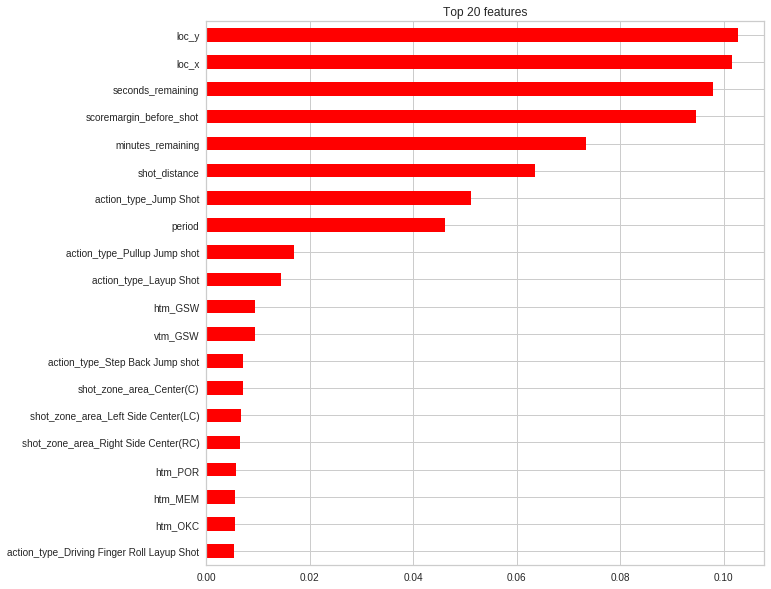

In [24]:
# Get feature importances
encoder = pipeline.named_steps['onehotencoder']
rf = pipeline.named_steps['randomforestclassifier']
feature_names = encoder.transform(X_train_subset).columns
importances = pd.Series(Rf.feature_importances_, feature_names)

#feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='red');

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred[:1168])

array([[276, 327],
       [300, 265]])

In [33]:
pipeline.named_steps['randomforestclassifier'].classes_

array([0, 1])

In [34]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array([0, 1])

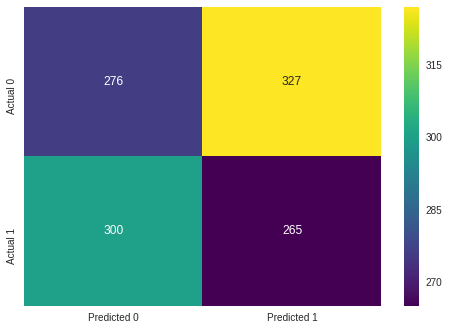

In [37]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
    
plot_confusion_matrix(y_val, y_pred[:1168]);

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred[:1168]))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47       603
           1       0.45      0.47      0.46       565

    accuracy                           0.46      1168
   macro avg       0.46      0.46      0.46      1168
weighted avg       0.46      0.46      0.46      1168



Logistic Regression

In [0]:
Lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    QuantileTransformer(),
    IterativeImputer(), 
    Lr
                                                                           
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train_subset, y_train)
print('Train Accuracy', pipeline.score(X_train_subset, y_train))
print('Validation Accuracy', pipeline.score(X_val_subset, y_val))
y_pred2 = pipeline.predict(X_test)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

In [45]:
#Accuracy on matrix
correct_predictions = 85 +36
total_predictions = 85 + 36 + 8 + 58
correct_predictions / total_predictions

0.6470588235294118

In [43]:
#Recall of Positive Matrix
precision_Pos = 36
total_predictions_pos = 8+58+36
precision_Pos/total_predictions_pos

0.35294117647058826

In [44]:
#Precision of matrix
actual_pos = 48
correct_pos = 36
correct_pos/actual_pos

0.75